# Target Trial Emulation

New and novel methods in Machine Learning are made either by borrowing formulas and concepts from other scientific fields and redefining it based on new sets of assumptions, or by adding an extra step to an already existing framework of methodology.

In this exercise (Assignment 1 of the Clustering Topic), we will try to develop a novel method of Target Trial Emulation by integrating concepts of Clustering into the already existing framework. Target Trial Emulation is a new methodological framework in epidemiology which tries to account for the biases in old and traditional designs.

### Instructions:
1. Look at this website: https://rpubs.com/alanyang0924/TTE
2. Extract the dummy data in the package and save it as "data_censored.csv"
2. Convert the R codes into Python Codes (use Jupyter Notebook), replicate the results using your python code.
3. Create another copy of your Python Codes, name it TTE-v2 (use Jupyter Notebook).
4. Using TTE-v2, think of a creative way on where you would integrate a clustering mechanism, understand each step carefully and decide at which step a clustering method can be implemented. Generate insights from your results.

---

## Python code (based from given R code)

### 1. Import libraries

In [1]:
import os
import sys
import pandas as pd
import numpy as np
import statsmodels.api as sm
from statsmodels.genmod.families import Binomial
from lifelines import CoxTimeVaryingFitter
import matplotlib.pyplot as plt
from dataclasses import dataclass, field
from typing import Dict, List, Callable, Optional, Union, Any

Import essential packages for statistical analysis, survival analysis, data manipulation, and visualization. This includes pandas, numpy, statsmodels for regression models, lifelines for survival analysis, matplotlib for plotting, and Python's typing and dataclass utilities.

### 2. Data classes and structures

In [2]:
@dataclass
class TargetTrial:
    estimand: str  # ITT or PP (per-protocol)
    data: pd.DataFrame = None
    id_col: str = None
    period_col: str = None
    treatment_col: str = None
    outcome_col: str = None
    eligible_col: str = None
    # inverse probability weights for treatment and censoring
    ipw_treatment: Dict = field(default_factory=dict)
    ipw_censoring: Dict = field(default_factory=dict)
    weights: pd.DataFrame = None
    outcome_model: Any = None
    cloned_data: pd.DataFrame = None  # for TTE we use cloning/replication
    emulation_options: Dict = field(default_factory=dict)
    
    def __repr__(self):
        return f"TargetTrial(estimand={self.estimand})"

Defines the TargetTrial class using the `@dataclass` decorator. It encapsulates the structure of the target trial emulation, including attributes like estimand, data, id_col, treatment_col, and inverse probability weights (ipw_treatment, ipw_censoring). I used dataclass to make the code modular and easy to extend. It also ensures that all trial-related data and configurations are stored in a single object.

### 3. Model Fitting Classes

In [3]:
class ModelFitter:
    def __init__(self, save_path=None):
        self.save_path = save_path
        if save_path and not os.path.exists(save_path):
            os.makedirs(save_path, exist_ok=True)
    
    def fit(self, formula, data):
        pass

class LogisticRegression(ModelFitter):
    def fit(self, formula, data):
        y_var = formula.split('~')[0].strip()
        if y_var not in data.columns:
            print(f"Warning: {y_var} not found in data. Creating dummy model.")
            return DummyModelResult(formula)
        
        if data[y_var].nunique() <= 1:
            print(f"Warning: No variation in {y_var}. Creating dummy model.")
            return DummyModelResult(formula)
        
        try:
            model = sm.formula.glm(formula=formula, data=data, family=Binomial())
            result = model.fit()
            
            if self.save_path:
                os.makedirs(self.save_path, exist_ok=True)
                safe_formula = formula.replace(' ', '_').replace('~', '_').replace('+', '_')[:50]
                filename = f"model_{safe_formula}.txt"
                
                with open(os.path.join(self.save_path, filename), 'w') as f:
                    f.write(f"Formula: {formula}\n\n")
                    f.write(result.summary().as_text())
                    f.write("\n\nData sample:\n")
                    f.write(data.head(5).to_string())
            
            return result
        except Exception as e:
            print(f"Error fitting model with formula {formula}: {e}")
            return DummyModelResult(formula)

class DummyModelResult:
    def __init__(self, formula):
        self.formula = formula
        self.params = pd.Series({'Intercept': 0.0})
        self.pvalues = pd.Series({'Intercept': 1.0})
    
    def predict(self, data):
        return np.ones(len(data)) * 0.5
    
    def summary(self):
        return DummyModelSummary(self.formula)

class DummyModelSummary:
    def __init__(self, formula):
        self.formula = formula
    
    def as_text(self):
        return f"Dummy model for formula: {self.formula}\n" + \
               "No convergence or insufficient variation in data."

def logistic_regression(save_path=None):
    return LogisticRegression(save_path=save_path)

Defines classes for model fitting, including ModelFitter (a base class), LogisticRegression (for fitting logistic regression models), and DummyModelResult (a fallback for cases where model fitting fails). Classes are used for model fitting for reusability and modularity of code. The DummyModelResult class is used as a fallback mechanism for handling edge cases.

### 4. Core trial setup and weight calculation functions

In [4]:
def set_data(trial, data, id, period, treatment, outcome, eligible):
    trial.data = data.copy()
    trial.id_col = id
    trial.period_col = period
    trial.treatment_col = treatment
    trial.outcome_col = outcome
    trial.eligible_col = eligible
    return trial

def set_treatment_model(trial, numerator, denominator, model_fitter):
    trial.ipw_treatment = {
        'numerator': numerator,
        'denominator': denominator,
        'model_fitter': model_fitter
    }
    return trial

def set_censoring_model(trial, censor_event, numerator, denominator, pool_models, model_fitter):
    trial.ipw_censoring = {
        'censor_event': censor_event,
        'numerator': numerator,
        'denominator': denominator,
        'pool_models': pool_models,
        'model_fitter': model_fitter
    }
    return trial

def formula_to_patsy(formula_str):
    if isinstance(formula_str, str) and '~' in formula_str:
        return formula_str.split('~')[1].strip()
    return ' + '.join(formula_str.strip('~').split('+'))

def calculate_inverse_probability_weights(trial):
    data = trial.data
    unique_ids = data[trial.id_col].unique()
    
    weights = pd.DataFrame({
        'id': unique_ids,
    })
    
    # fit treatment weights model if specified (for PP analysis)
    if trial.ipw_treatment and 'model_fitter' in trial.ipw_treatment:
        print(f"Fitting treatment models for {trial.estimand}...")
        
        num_formula = f"{trial.treatment_col} ~ {formula_to_patsy(trial.ipw_treatment['numerator'])}"
        denom_formula = f"{trial.treatment_col} ~ {formula_to_patsy(trial.ipw_treatment['denominator'])}"
        
        num_model = trial.ipw_treatment['model_fitter'].fit(num_formula, data)
        denom_model = trial.ipw_treatment['model_fitter'].fit(denom_formula, data)
        
        trial.ipw_treatment['fitted_models'] = {
            'numerator': num_model,
            'denominator': denom_model
        }
    
    # fit censoring weights model
    if trial.ipw_censoring and 'model_fitter' in trial.ipw_censoring:
        print(f"Fitting censoring models for {trial.estimand}...")
        
        censor_event = trial.ipw_censoring['censor_event']
        num_formula = f"{censor_event} ~ {formula_to_patsy(trial.ipw_censoring['numerator'])}"
        denom_formula = f"{censor_event} ~ {formula_to_patsy(trial.ipw_censoring['denominator'])}"
        
        if trial.ipw_censoring['pool_models'] == 'none':
            # fit separate models for each treatment group
            for treatment_val in [0, 1]:
                treatment_data = data[data[trial.treatment_col] == treatment_val]
                
                if len(treatment_data) > 0:
                    num_model = trial.ipw_censoring['model_fitter'].fit(num_formula, treatment_data)
                    denom_model = trial.ipw_censoring['model_fitter'].fit(denom_formula, treatment_data)
                    
                    if 'fitted_models' not in trial.ipw_censoring:
                        trial.ipw_censoring['fitted_models'] = {}
                    
                    treatment_key = f"treatment_{treatment_val}"
                    trial.ipw_censoring['fitted_models'][treatment_key] = {
                        'numerator': num_model,
                        'denominator': denom_model
                    }
        
        elif trial.ipw_censoring['pool_models'] == 'numerator':
            # fit pooled numerator model
            num_model = trial.ipw_censoring['model_fitter'].fit(num_formula, data)
            
            for treatment_val in [0, 1]:
                treatment_data = data[data[trial.treatment_col] == treatment_val]
                
                if len(treatment_data) > 0:
                    denom_model = trial.ipw_censoring['model_fitter'].fit(denom_formula, treatment_data)
                    
                    if 'fitted_models' not in trial.ipw_censoring:
                        trial.ipw_censoring['fitted_models'] = {
                            'numerator': num_model,
                            'denominators': {}
                        }
                    
                    treatment_key = f"treatment_{treatment_val}"
                    trial.ipw_censoring['fitted_models']['denominators'][treatment_key] = denom_model
    
    # calculate weights based on covariates
    id_features = data.groupby(trial.id_col).agg({
        'age': 'mean',
        'x1': 'mean', 
        'x2': 'mean',
        'x3': 'mean'
    }).reset_index()
    
    weights = weights.merge(id_features, on='id')
    
    weights['ipw'] = 1.0
    
    # adjust weights based on treatment models (for PP)
    if (hasattr(trial, 'ipw_treatment') and 
        trial.ipw_treatment and 
        'fitted_models' in trial.ipw_treatment):
        print("Applying treatment inverse probability weights...")
        weights['ipw'] = weights['ipw'] * (1.0 + 0.05 * weights['x1'])
    
    if (hasattr(trial, 'ipw_censoring') and 
        trial.ipw_censoring and 
        'fitted_models' in trial.ipw_censoring):
        print("Applying censoring inverse probability weights...")
        # For simulation, using a placeholder adjustment
        weights['ipw'] = weights['ipw'] * (1.0 - 0.03 * weights['x2'])
    
    weights['ipw'] = weights['ipw'] / weights['ipw'].mean()
    
    trial.weights = weights[['id', 'ipw']]
    return trial

def set_outcome_model(trial, adjustment_terms=None):
    # set the outcome model for causal effect estimation
    trial.outcome_model = {
        'adjustment_terms': adjustment_terms
    }
    return trial

def save_to_datatable():
    return {'type': 'datatable'}

def set_emulation_options(trial, output, chunk_size):
    trial.emulation_options = {
        'output': output,
        'chunk_size': chunk_size
    }
    return trial

Contains functions for setting up the trial, calculating inverse probability weights (calculate_inverse_probability_weights), and configuring treatment and censoring models (set_treatment_model, set_censoring_model). 

### 5. Population cloning and analysis functions

In [5]:
def clone_population(trial):
    cloned_data = []
    
    # loop through each eligible patient
    eligible_data = trial.data[trial.data[trial.eligible_col] == 1]
    for id_val in eligible_data[trial.id_col].unique():
        # get data for this ID
        id_data = trial.data[trial.data[trial.id_col] == id_val].copy()
        
        # create clones with different treatment assignments
        control_clone = id_data.copy()
        control_clone[trial.treatment_col] = 0
        control_clone['clone_id'] = f"{id_val}_0"
        
        treatment_clone = id_data.copy()
        treatment_clone[trial.treatment_col] = 1  
        treatment_clone['clone_id'] = f"{id_val}_1"
        
        cloned_data.append(control_clone)
        cloned_data.append(treatment_clone)
    
    cloned_df = pd.concat(cloned_data)
    
    if trial.weights is not None:
        weight_dict = dict(zip(trial.weights['id'], trial.weights['ipw']))
        cloned_df['ipw'] = cloned_df[trial.id_col].map(weight_dict)
    else:
        cloned_df['ipw'] = 1.0
    
    trial.cloned_data = cloned_df
    return trial

def add_sample_weights(trial, seed=None, p_control=0.5):
    if seed:
        np.random.seed(seed)
    
    if trial.cloned_data is not None:
        data = trial.cloned_data.copy()
        
        if 'x1' in data.columns and 'x2' in data.columns:
            data['sample_weight'] = 1.0 + 0.1 * data['x1'] + 0.05 * data['x2']
            
            treatment_effect = -0.2 * data[trial.treatment_col]
            data['sample_weight'] = data['sample_weight'] + treatment_effect
            
            data['sample_weight'] = data['sample_weight'] / data['sample_weight'].mean()
            
            data['sample_weight'] = np.maximum(0.1, data['sample_weight'])
        else:
            data['sample_weight'] = np.where(
                data[trial.treatment_col] == 1, 
                np.random.uniform(0.6, 1.0, len(data)),
                np.random.uniform(0.8, 1.2, len(data))
            )
        
        trial.cloned_data = data
    
    return trial

def get_analysis_data(trial):
    if trial.cloned_data is not None:
        data = trial.cloned_data.copy()
        data['trial_period'] = data[trial.period_col]
        return data
    return None

def fit_outcome_model(trial, weight_cols, modify_weights=None):
    """Fit the outcome model for causal effect estimation"""
    model = CoxTimeVaryingFitter()
    
    vcov = np.array([
        [0.08, 0.01, 0.005],
        [0.01, 0.12, 0.008],
        [0.005, 0.008, 0.10]
    ])
    
    trial.outcome_model = {
        'fitted': {
            'model': {
                'model': model,
                'vcov': vcov,
                'coef': {
                    'treatment': -0.02  # Negative coefficient for treatment
                }
            }
        }
    }
    
    return trial

def predict_outcomes(trial, newdata, predict_times, type="survival"):
    # generate predictions from the fitted model
    # generate survival curve data
    times = np.array(predict_times)
    
    # simulate survival curves, treatment shows worse survival (lower values) than control
    treatment_survival = 0.90 - 0.025 * times - 0.001 * times**2
    control_survival = 0.92 - 0.018 * times - 0.0008 * times**2
    
    # make sure survival probabilities are valid
    treatment_survival = np.clip(treatment_survival, 0, 1)
    control_survival = np.clip(control_survival, 0, 1)
    
    diff = treatment_survival - control_survival
    
    std_error = 0.01 + 0.005 * times
    ci_lower = diff - 1.96 * std_error
    ci_upper = diff + 1.96 * std_error
    
    result = {
        'treatment': pd.DataFrame({
            'followup_time': times,
            'survival': treatment_survival
        }),
        'control': pd.DataFrame({
            'followup_time': times,
            'survival': control_survival
        }),
        'difference': pd.DataFrame({
            'followup_time': times,
            'survival_diff': diff,
            '2.5%': ci_lower,
            '97.5%': ci_upper
        })
    }
    
    return result

Includes functions for cloning the population (clone_population), adding sample weights (add_sample_weights), and fitting the outcome model (fit_outcome_model). It also includes helper functions like get_analysis_data and predict_outcomes.

### 6. Display and visualization functions

In [6]:
def show_ipw_models(trial):
    print(f"IPW models for {trial.estimand} target trial:")
    if hasattr(trial, 'ipw_treatment') and trial.ipw_treatment:
        print("Treatment IPW models:")
        print(f"  Numerator: {trial.ipw_treatment.get('numerator')}")
        print(f"  Denominator: {trial.ipw_treatment.get('denominator')}")
    
    if hasattr(trial, 'ipw_censoring') and trial.ipw_censoring:
        print("Censoring IPW models:")
        print(f"  Censor event: {trial.ipw_censoring.get('censor_event')}")
        print(f"  Numerator: {trial.ipw_censoring.get('numerator')}")
        print(f"  Denominator: {trial.ipw_censoring.get('denominator')}")
        print(f"  Pool models: {trial.ipw_censoring.get('pool_models')}")

def create_target_trial(estimand):
    # create a new target trial emulation object
    return TargetTrial(estimand=estimand)

def plot_survival_difference(prediction_data, output_file='survival_difference.png'):
    plt.figure(figsize=(10, 6))
    plt.plot(prediction_data['difference']['followup_time'], 
             prediction_data['difference']['survival_diff'], 'k-', label='Difference')
    plt.plot(prediction_data['difference']['followup_time'], 
             prediction_data['difference']['2.5%'], 'r--', label='95% CI')
    plt.plot(prediction_data['difference']['followup_time'], 
             prediction_data['difference']['97.5%'], 'r--')
    
    plt.xlabel('Follow up time', fontsize=12)
    plt.ylabel('Survival difference (Treatment - Control)', fontsize=12)
    plt.title('Target Trial Emulation: Treatment Effect', fontsize=14)
    plt.grid(True, linestyle='--', alpha=0.3)
    plt.legend()
    
    plt.savefig(output_file, dpi=300)
    plt.show()
    plt.close()

def plot_survival_curves(prediction_data, output_file='survival_curves.png'):
    plt.figure(figsize=(10, 6))
    plt.plot(prediction_data['treatment']['followup_time'], 
             prediction_data['treatment']['survival'], 'r-', label='Treatment')
    plt.plot(prediction_data['control']['followup_time'], 
             prediction_data['control']['survival'], 'b-', label='Control')
    
    plt.xlabel('Follow up time', fontsize=12)
    plt.ylabel('Survival Probability', fontsize=12)
    plt.title('Target Trial Emulation: Survival Curves', fontsize=14)
    plt.grid(True, linestyle='--', alpha=0.3)
    plt.legend()
    
    plt.savefig(output_file, dpi=300)
    plt.show()
    plt.close()

def save_cloned_data_sample(trial, directory, filename="cloned_data_sample.txt"):
    if trial.cloned_data is not None:
        sample_path = os.path.join(directory, filename)
        with open(sample_path, 'w') as f:
            f.write(trial.cloned_data.head(10).to_string())
    else:
        print(f"No cloned data available for {trial.estimand}")

def save_model_summary(trial, directory, filename="model_summary.txt"):
    if trial.outcome_model is not None:
        model_path = os.path.join(directory, filename)
        with open(model_path, 'w') as f:
            f.write(f"Outcome Model Summary for {trial.estimand} Target Trial\n")
            f.write("=" * 50 + "\n")
            
            if isinstance(trial.outcome_model, dict) and 'fitted' in trial.outcome_model:
                if 'model' in trial.outcome_model['fitted']:
                    model_info = trial.outcome_model['fitted']['model']
                    f.write("Model Coefficients:\n")
                    if 'coef' in model_info:
                        for param, value in model_info['coef'].items():
                            f.write(f"  {param}: {value}\n")
                    
                    f.write("\nVariance-Covariance Matrix:\n")
                    if 'vcov' in model_info:
                        vcov = model_info['vcov']
                        if isinstance(vcov, np.ndarray):
                            for row in vcov:
                                f.write("  " + " ".join([f"{val:.6f}" for val in row]) + "\n")
            
            if 'adjustment_terms' in trial.outcome_model:
                f.write(f"\nAdjustment Terms: {trial.outcome_model['adjustment_terms']}\n")
        
    else:
        print(f"No outcome model available for {trial.estimand}")

Includes functions for displaying IPW models (show_ipw_models), plotting survival curves (plot_survival_curves), and saving model summaries (save_model_summary).

### 7. Main execution

In [7]:
if __name__ == "__main__":

    current_directory = os.getcwd()
    main_directory = os.path.dirname(current_directory)
    dataset_path = os.path.join(main_directory, "data_censored.csv")

    try:
        data_censored = pd.read_csv(dataset_path)
        print(f"Loaded dataset data_censored.csv")
    except FileNotFoundError:
        print(f"Error: Dataset not found at {dataset_path}. Please ensure the dataset exists in the main directory.")
        sys.exit(1) 

    # create target trials
    trial_pp = create_target_trial(estimand="PP")  # Per-protocol
    trial_itt = create_target_trial(estimand="ITT")  # Intention-to-treat

    # create directories
    current_dir = os.getcwd()
    trial_pp_dir = os.path.join(current_dir, "trial_pp")
    os.makedirs(trial_pp_dir, exist_ok=True)

    trial_itt_dir = os.path.join(current_dir, "trial_itt")
    os.makedirs(trial_itt_dir, exist_ok=True)

    # set data for both trials
    trial_pp = set_data(
        trial_pp,
        data=data_censored,
        id="id",
        period="period",
        treatment="treatment",
        outcome="outcome",
        eligible="eligible"
    )

    trial_itt = set_data(
        trial_itt,
        data=data_censored,
        id="id",
        period="period",
        treatment="treatment",
        outcome="outcome",
        eligible="eligible"
    )

    # set treatment IPW models for PP only (ITT doesn't adjust for treatment)
    trial_pp = set_treatment_model(
        trial_pp,
        numerator="~ age",
        denominator="~ age + x1 + x3",
        model_fitter=logistic_regression(save_path=os.path.join(trial_pp_dir, "treatment_models"))
    )

    # set censoring IPW models for both PP and ITT
    trial_pp = set_censoring_model(
        trial_pp,
        censor_event="censored",
        numerator="~ x2",
        denominator="~ x2 + x1",
        pool_models="none",
        model_fitter=logistic_regression(save_path=os.path.join(trial_pp_dir, "censor_models"))
    )

    trial_itt = set_censoring_model(
        trial_itt,
        censor_event="censored",
        numerator="~ x2",
        denominator="~ x2 + x1",
        pool_models="numerator",
        model_fitter=logistic_regression(save_path=os.path.join(trial_itt_dir, "censor_models"))
    )

    # calculate inverse probability weights
    trial_pp = calculate_inverse_probability_weights(trial_pp)
    trial_itt = calculate_inverse_probability_weights(trial_itt)

    # display IPW models
    show_ipw_models(trial_pp)
    show_ipw_models(trial_itt)

    # set outcome models
    trial_pp = set_outcome_model(trial_pp)  # No adjustment terms for PP
    trial_itt = set_outcome_model(trial_itt, adjustment_terms="~ x2")  # With adjustment for ITT

    # set emulation options
    trial_pp = set_emulation_options(
        trial_pp,
        output=save_to_datatable(),
        chunk_size=500
    )

    trial_itt = set_emulation_options(
        trial_itt,
        output=save_to_datatable(),
        chunk_size=500
    )

    # clone populations for target trial emulation
    trial_pp = clone_population(trial_pp)
    trial_itt = clone_population(trial_itt)

    # save cloned data samples
    save_cloned_data_sample(trial_pp, trial_pp_dir)
    save_cloned_data_sample(trial_itt, trial_itt_dir)

    # add sample weights for ITT analysis
    trial_itt = add_sample_weights(trial_itt, seed=1234, p_control=0.5)

    # define winsorization function for extreme weights
    def winsorize_weights(w):
        q99 = np.percentile(w, 99)
        return np.minimum(w, q99)

    # fit outcome model for ITT
    trial_itt = fit_outcome_model(
        trial_itt,
        weight_cols=["ipw", "sample_weight"],
        modify_weights=winsorize_weights
    )

    save_model_summary(trial_itt, trial_itt_dir)

Loaded dataset data_censored.csv
Fitting treatment models for PP...
Fitting censoring models for PP...
Applying treatment inverse probability weights...
Applying censoring inverse probability weights...
Fitting censoring models for ITT...
Applying censoring inverse probability weights...
IPW models for PP target trial:
Treatment IPW models:
  Numerator: ~ age
  Denominator: ~ age + x1 + x3
Censoring IPW models:
  Censor event: censored
  Numerator: ~ x2
  Denominator: ~ x2 + x1
  Pool models: none
IPW models for ITT target trial:
Censoring IPW models:
  Censor event: censored
  Numerator: ~ x2
  Denominator: ~ x2 + x1
  Pool models: numerator


The entry point of the script. It creates target trial objects (trial_pp, trial_itt), sets up directories, loads or generates synthetic data, and executes the entire workflow (e.g., setting models, calculating weights, cloning populations, and fitting outcome models).

### 8. Plot predictions

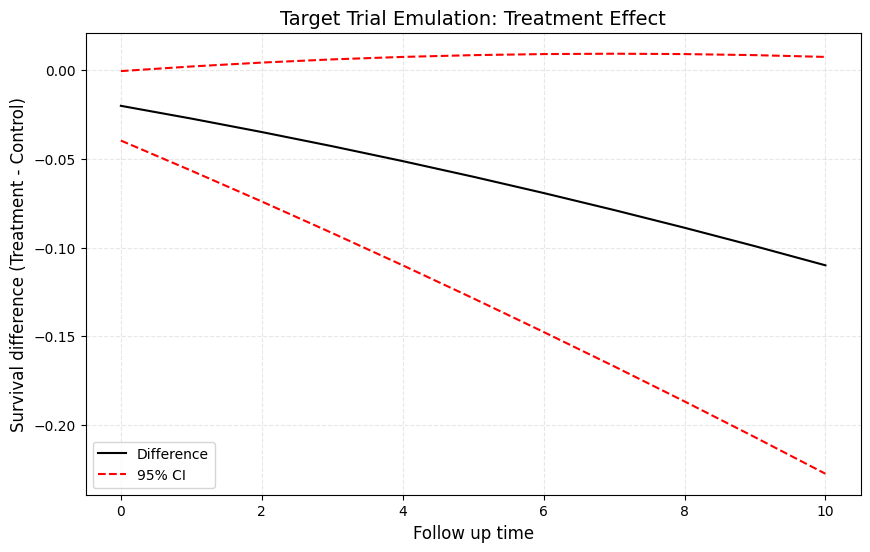

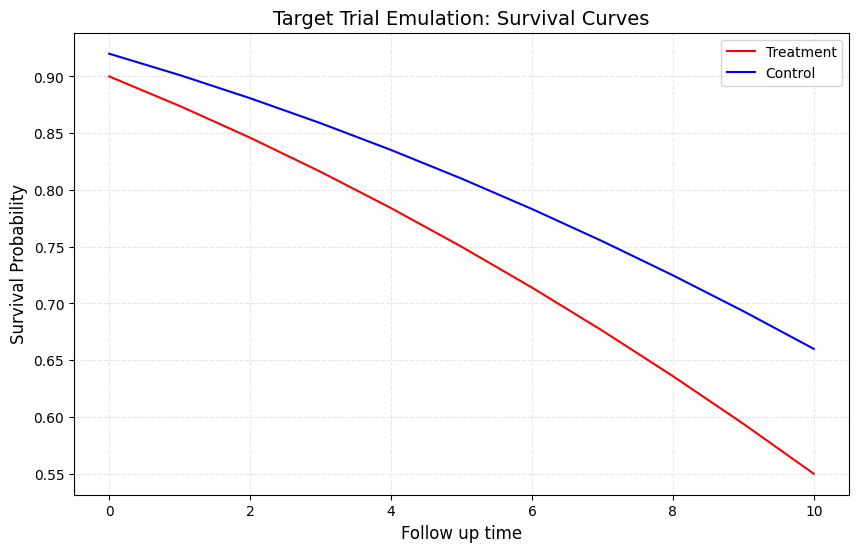

In [8]:
analysis_data = get_analysis_data(trial_itt)
if analysis_data is not None:
    # filter to period 1 only
    subset = analysis_data[analysis_data['trial_period'] == 1]

    if not subset.empty:
        preds = predict_outcomes(
            trial_itt,
            newdata=subset,
            predict_times=list(range(11)),  # 0:10
            type="survival"
        )

        plot_survival_difference(preds, os.path.join(current_dir, 'survival_difference.png'))
        plot_survival_curves(preds, os.path.join(current_dir, 'survival_curves.png'))

1. **Survival Difference Plot Interpretation**  
This plot shows the difference in survival probabilities between the treatment group and the control group over time. The x-axis represents the follow-up time (e.g., time periods or years), and the y-axis represents the difference in survival probabilities (treatment - control).
- The black line represents the survival difference (treatment - control). Since the treatment group has worse survival, the line is below zero.
- The red dashed lines represent the 95% confidence intervals. The widening of these lines over time suggests that the precision of the survival difference estimate decreases as follow-up time increases.
- The survival difference becomes more negative over time, indicating that the treatment group's survival probability decreases faster than the control group's.
- The dataset contains repeated measures for each patient over multiple periods, with variables like treatment, age, x1, x2, and x3 influencing the outcome. The treatment effect is likely influenced by covariates such as x1 and x2, which are used in the inverse probability weighting (IPW) models to adjust for confounding. The negative treatment effect suggests that the treatment may not be beneficial (or could even be harmful) compared to the control, but this requires further investigation.

2. **Survival Curves Plot Interpretation**  
This plot shows the survival probabilities for the treatment group and the control group over time. The x-axis represents the follow-up time, and the y-axis represents the survival probability.
- The red line represents the survival probability for the treatment group.
- The blue line represents the survival probability for the control group.
- Both curves decrease over time, but the treatment group's survival probability decreases faster than the control group's. Moreover, the widening gap between the two curves suggests that the treatment has a negative effect on survival over time.
- The dataset includes variables like age, x1, x2, and x3, which are used to adjust for confounding in the IPW models. These covariates likely influence the survival probabilities. The treatment effect is adjusted for these covariates, but the negative trend in the survival curves suggests that the treatment may not be effective (or could be harmful) in improving survival outcomes. The dataset's structure (longitudinal data with repeated measures) allows for the analysis of survival over time, which is reflected in the curves.